<a href="https://colab.research.google.com/github/UN-GCPDS/python-gcpds.EEG_Tensorflow_models/blob/main/Experimental/Explanation_maps/Confidence_score_CAMs_mnist_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
%cd /content/drive/MyDrive/research UNAL/Doctorado/Semestre 3/Trabajo_con_Andres/notebooks

/content/drive/MyDrive/research UNAL/Doctorado/Semestre 3/Trabajo_con_Andres/notebooks


In [ ]:
#%pip install git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models.git@dggm#egg=EEG_Tensorflow_models

In [2]:
!pip install scikeras[tensorflow] > /dev/null
!pip install tf-keras-vis tensorflow > /dev/null

In [3]:
# from EEG_Tensorflow_models.Utils.LoadData import load_dataset,get_classes,get_data_from_BaseConcatDataset
# from EEG_Tensorflow_models.Utils.Callbacks import get_callbacks
# from EEG_Tensorflow_models.Utils.TrainingModels import get_loss,get_model,get_optimizer,train_model_cv
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
#from EEG_Tensorflow_models.Utils.Attention_maps import Attention_maps
import numpy as np
import pandas as pd
from skimage import filters
from scikeras.wrappers import KerasClassifier
from functools import partial
from sklearn.model_selection import GridSearchCV

In [4]:
#cargar fashion mnist o mnist
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid = X_train[:-55000], X_train[-55000:]
y_train, y_valid = y_train[:-55000], y_train[-55000:]
 
X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.
print(X_train.shape,X_valid.shape,X_test.shape)

(5000, 28, 28, 1) (55000, 28, 28, 1) (10000, 28, 28, 1)


In [5]:
tf.keras.backend.clear_session()

In [6]:
def create_model(l1, l2, dp1, dp2):

  DefaultConv2D = partial(tf.keras.layers.Conv2D,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),
                          activation='relu', padding="SAME")
  DefaultDense = partial(tf.keras.layers.Dense,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))

  tf.keras.backend.clear_session()
  inputA= tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]), name='input')
  tmp = tf.keras.layers.BatchNormalization()(inputA)
  tmp = DefaultConv2D(filters=16, kernel_size=7,name='cnn_0')(inputA)
  tmp = tf.keras.layers.BatchNormalization()(tmp)
  tmp = tf.keras.layers.MaxPooling2D(pool_size=2)(tmp)
  tmp = tf.keras.layers.BatchNormalization()(tmp)
  tmp = DefaultConv2D(filters=32, kernel_size=3,name='cnn_1')(tmp)
  tmp = tf.keras.layers.BatchNormalization()(tmp)
  tmp = tf.keras.layers.MaxPooling2D(pool_size=2)(tmp)
  tmp = tf.keras.layers.BatchNormalization()(tmp)
  tmp = DefaultConv2D(filters=32, kernel_size=3,name='cnn_2')(tmp)
  tmp = tf.keras.layers.BatchNormalization()(tmp)
  tmp = tf.keras.layers.Flatten()(tmp)
  tmp = DefaultDense(units=64,name='dense_0')(tmp)
  tmp = tf.keras.layers.BatchNormalization()(tmp)
  tmp = tf.keras.layers.Dropout(dp1)(tmp) # regularizar, apagar aleatoriamente neuronas
  tmp = DefaultDense(units=32,name='dense_1')(tmp)
  tmp = tf.keras.layers.BatchNormalization()(tmp)
  tmp = tf.keras.layers.Dropout(dp2)(tmp)
  tmp = tf.keras.layers.Dense(units=10,name='out')(tmp)
  output = tf.keras.layers.Activation(tf.nn.softmax)(tmp)
  model = tf.keras.Model(inputs=[inputA],outputs=[output])  
  model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=["accuracy"])
  return model

In [7]:
#training
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
skeras_learn_model = KerasClassifier(model=create_model,epochs=30, batch_size=128,
                                     model__l1=0,
                                     model__l2=0,
                                     model__dp1=0,
                                     model__dp2=0,
                                     #validation_split=0.2,
                                     verbose=100,
                                     #callbacks=[mycallback()],
                                     )
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),batch_size=128,callbacks=[mycallback()])

In [8]:
# params={'model__l1':np.float_power(10,[-1,-2,-3]),
#         'model__l2':np.float_power(10,[-1,-2,-3]),
#         'model__dp1':[0,0.25,0.5,0.75],
#         'model__dp2':[0,0.25,0.5,0.75]
# }
## bestparams
params={'model__l1':[0.001],
        'model__l2':[0.001],
        'model__dp1':[0.75],
        'model__dp2':[0.75]
}

In [9]:
search = GridSearchCV(skeras_learn_model,params,cv=2,verbose=1000,n_jobs=-1)
%time search.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
CPU times: user 18.8 s, sys: 1.88 s, total: 20.7 s
Wall time: 53.9 s


GridSearchCV(cv=2,
             estimator=KerasClassifier(batch_size=128, epochs=30, model=<function create_model at 0x7f1f7c417050>, model__dp1=0, model__dp2=0, model__l1=0, model__l2=0, verbose=100),
             n_jobs=-1,
             param_grid={'model__dp1': [0.75], 'model__dp2': [0.75],
                         'model__l1': [0.001], 'model__l2': [0.001]},
             verbose=1000)

In [10]:
best_est = search.best_estimator_
best_score = search.best_score_
best_params = search.best_params_
print('Best score obtained after GridSearchCV: ', best_score)
print('Best params obtained after GridSearchCV: ', best_params)

Best score obtained after GridSearchCV:  0.9176
Best params obtained after GridSearchCV:  {'model__dp1': 0.75, 'model__dp2': 0.75, 'model__l1': 0.001, 'model__l2': 0.001}


In [11]:
print(search.cv_results_['mean_test_score'])
print(search.cv_results_['std_test_score'])

[0.9176]
[0.0012]


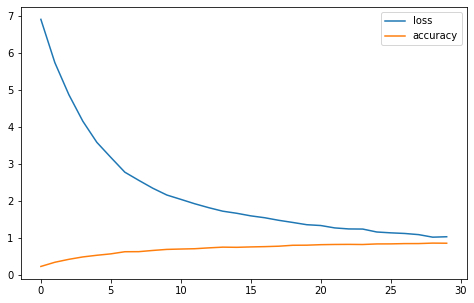

In [12]:
pd.DataFrame(best_est.history_).plot(figsize=(8, 5))

In [13]:
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
history=best_est.model_.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),batch_size=128,callbacks=[checkpoint])

Epoch 1/30
38/40 [===========================>..] - ETA: 0s - loss: 0.9850 - accuracy: 0.8489
Epoch 1: val_loss improved from inf to 0.74348, saving model to my_best_model.hdf5
40/40 [==============================] - 5s 96ms/step - loss: 0.9840 - accuracy: 0.8486 - val_loss: 0.7435 - val_accuracy: 0.9533
Epoch 2/30
37/40 [==========================>...] - ETA: 0s - loss: 0.9562 - accuracy: 0.8625
Epoch 2: val_loss did not improve from 0.74348
40/40 [==============================] - 3s 78ms/step - loss: 0.9614 - accuracy: 0.8612 - val_loss: 0.7958 - val_accuracy: 0.9357
Epoch 3/30
38/40 [===========================>..] - ETA: 0s - loss: 0.9812 - accuracy: 0.8470
Epoch 3: val_loss did not improve from 0.74348
40/40 [==============================] - 2s 61ms/step - loss: 0.9828 - accuracy: 0.8468 - val_loss: 0.8134 - val_accuracy: 0.9266
Epoch 4/30
39/40 [============================>.] - ETA: 0s - loss: 0.9151 - accuracy: 0.8654
Epoch 4: val_loss improved from 0.74348 to 0.73694, savin

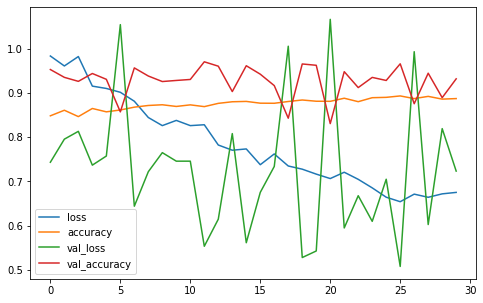

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

In [15]:
score   = best_est.model_.evaluate(X_test, y_test)
print(score)

313/313 [==============================] - 2s 5ms/step - loss: 0.6995 - accuracy: 0.9335
[0.6995439529418945, 0.9334999918937683]


In [16]:
best_est.model_.load_weights(filepath)
score   = best_est.model_.evaluate(X_test, y_test)
print(score)

313/313 [==============================] - 2s 5ms/step - loss: 0.4897 - accuracy: 0.9694
[0.48970526456832886, 0.9693999886512756]


In [17]:
#--------------------##--------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.layercam import Layercam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from sklearn.metrics import pairwise_distances
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import re
import functools
#--------------------##--------------------------------------


def centroid_(X):
   D = pairwise_distances(X, X.mean(axis=0).reshape(1,-1))
   inertia_ = D.mean()
   return np.argmin(D),inertia_

def plot_attention(tmpr_,layer_name,list_class,figsize=(10,5), transpose=False):
    
    
    if transpose:
      x_label_list = layer_name 
      nC = len(list_class)
      nl = len(layer_name)
      ncols,nrows = tmpr_.shape

      y_label_list = []
      for ii in range(nC):
          y_label_list += str(list_class[ii])

      dw = nrows/nl
      list_xticks = []
      for ii in range(nl):
        list_xticks += [int(dw*(0.5+ii))]
      dw = ncols/nC
      list_yticks = []
      for ii in range(nC):
        list_yticks += [int(dw*(0.5+ii))]

    else:
      y_label_list = layer_name 
      nC = len(list_class)
      nl = len(layer_name)
      nrows,ncols = tmpr_.shape

      x_label_list = []
      for ii in range(nC):
          x_label_list += str(list_class[ii])

      dw = nrows/nl
      list_yticks = []
      for ii in range(nl):
        list_yticks += [int(dw*(0.5+ii))]
      dw = ncols/nC
      list_xticks = []
      for ii in range(nC):
        list_xticks += [int(dw*(0.5+ii))]
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    im = ax.imshow(tmpr_)
    im = ax.imshow(tmpr_)
    ax.set_yticks(list_yticks)
    ax.set_yticklabels(y_label_list)
    ax.set_xticks(list_xticks)
    ax.set_xticklabels(x_label_list,rotation = 'vertical') #
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
        
    plt.colorbar(im, cax=cax,extend='both',
                 ticks=[np.round(tmpr_.min(),1), np.round(0.5*(tmpr_.max()-tmpr_.min()),1), np.round(tmpr_.max(),1)])
    #plt.yticks(rotation=45)

       
    plt.tight_layout()    
    plt.show()
    return

def attention_wide(modelw,rel_model_name,layer_name,X_train,y_train,
                   normalize_cam=False,norm_max_min=False,norm_c=True,
                   plot_int=False,centroid_=False,smooth_samples=20,
                   smooth_noise=0.20,transpose=False,layer_norm=True,gamma=2):
    #-------------------------------------------------------------------------------
    # define trial sample to visualize
    # change activations of last layer by linear
    replace2linear = ReplaceToLinear()
    #relevance model
    if rel_model_name == 'Gradcam':
        gradcamw = Gradcam(modelw,
                        model_modifier=replace2linear,
                        clone=True)
    elif rel_model_name == 'Gradcam++':
        gradcamw = GradcamPlusPlus(modelw,
                              model_modifier=replace2linear,
                              clone=True) 
        
    elif rel_model_name == 'Scorecam':
        scorecamw = Scorecam(modelw)
        
    elif rel_model_name == 'Saliency':
          saliencyw = Saliency(modelw,
                              model_modifier=replace2linear,
                              clone=True)
    elif rel_model_name == 'Layercam':
          layercamcam = Layercam(modelw,
                              model_modifier=replace2linear,
                              clone=True)
          #layer_name = [''] #saliency doesn't depend on different layers    
    nC = len(np.unique(y_train))
    relM = [None]*nC
    if type(X_train)==list:
        n_inputs = len(X_train)
        new_input = [None]*n_inputs

    for c in range(len(np.unique(y_train))):  
      id_sample = y_train == np.unique(y_train)[c]

      if (type(X_train)==list) and (rel_model_name != 'Saliency'):
        relM[c] = np.zeros((sum(id_sample),X_train[0].shape[1],X_train[0].shape[2],len(layer_name)))
        #print(1,relM[c].shape)
      elif (type(X_train)==list) and (rel_model_name == 'Saliency'):   
        relM[c] = np.zeros((sum(id_sample),X_train[0].shape[1],X_train[0].shape[2],len(X_train)))
        #print(2,relM[c].shape)        
      else:
        relM[c] = np.zeros((sum(id_sample),X_train.shape[1],X_train.shape[2],len(layer_name)))
        #print(3,relM[c].shape)
      score = CategoricalScore(list(y_train[id_sample])) #-> [0] para probar a una clase diferente
      if type(X_train)==list:
          for ni in range(n_inputs):
              new_input[ni] = X_train[ni][id_sample]
      else:
        new_input = X_train[id_sample]        
      #print('rel',rel_model_name,'layer',layer_name[l])
      for l in range(len(layer_name)):
          print(rel_model_name,'class', np.unique(y_train)[c],'layer',layer_name[l])
      # label score -> target label accoring to the database
      #-----------------------------------------------------------------------------
      # generate heatmap with GradCAM
          if (rel_model_name == 'Gradcam') or (rel_model_name == 'Gradcam++'):
              rel = gradcamw(score,
                          new_input,
                          penultimate_layer=layer_name[l], #layer to be analized
                          expand_cam=True,
                          normalize_cam=normalize_cam)
          elif rel_model_name == 'Saliency': #saliency map is too noisy, so let’s remove noise in the saliency map using SmoothGrad!
              rel = saliencyw(score, new_input,smooth_samples=smooth_samples,
                                smooth_noise=smooth_noise,normalize_map=normalize_cam) #, smooth_samples=20,smooth_noise=0.20) # The number of calculating gradients iterations.
                            
          elif rel_model_name == 'Scorecam':     
              rel = scorecamw(score, new_input, penultimate_layer=layer_name[l], #layer to be analized
                          expand_cam=True,
                          normalize_cam=normalize_cam) #max_N=10 -> faster scorecam

          elif rel_model_name == 'Layercam':     
              rel = layercamcam(score,
                          new_input,
                          penultimate_layer=layer_name[l], #layer to be analized
                          expand_cam=True,
                          normalize_cam=normalize_cam)
          if layer_norm:
            rel = np.tanh(gamma*rel/np.max(rel))
          #save model
          if rel_model_name != 'Saliency':
            if type(X_train)==list: 
              tcc = rel[0]
            else: 
              tcc = rel
            dimc = tcc.shape
            tccv = tcc.ravel()
            tccv[np.isnan(tccv)] = 0
            tcc = tccv.reshape(dimc)
            if norm_max_min: #normalizing along samples
              tcc = MinMaxScaler().fit_transform(tcc.reshape(dimc[0],-1).T).T
              tcc = tcc.reshape(dimc)
            relM[c][...,l] = tcc
            if l==0: 
              tmp = np.median(relM[c][...,l],axis=0)#relM[c][...,l].mean(axis=0)
            else: 
              if transpose:
                tmp = np.c_[tmp,np.median(relM[c][...,l],axis=0)]#np.r_[tmp,relM[c][...,l].mean(axis=0)]  #centroid
              else:  
                tmp = np.r_[tmp,np.median(relM[c][...,l],axis=0)]#np.r_[tmp,relM[c][...,l].mean(axis=0)]  #centroid
          else: #saliency
            if type(X_train)==list: 
              tcc = np.zeros((rel[0].shape[0],rel[0].shape[1],rel[0].shape[2],len(rel)))
              for ii in range(len(rel)):
                  tcc[...,ii] = rel[ii]
            else: 
              tcc = rel
            dimc = tcc.shape
            tccv = tcc.ravel()
            tccv[np.isnan(tccv)] = 0
            tcc = tccv.reshape(dimc)
            if norm_max_min: #normalizing along samples
              tcc = MinMaxScaler().fit_transform(tcc.reshape(dimc[0],-1).T).T
              tcc = tcc.reshape(dimc)
            relM[c] = tcc
            if type(X_train)==list: 
              tmp = np.median(tcc[...,0],axis=0)
              for ii in range(len(rel)-1):
                  if transpose: 
                    tmp = np.c_[tmp,np.median(tcc[...,ii+1],axis=0)]
                  else:
                    tmp = np.r_[tmp,np.median(tcc[...,ii+1],axis=0)]
            else:
               tmp = np.median(tcc,axis=0)
                
      if norm_c: #normalizing along layers
        tmp = tmp/(1e-8+tmp.max())
      if c==0: 
        tmpr = tmp
      else:  
        if transpose:
          tmpr = np.r_[tmpr,tmp]  
        else:
          tmpr = np.c_[tmpr,tmp]  
      #print(tmp.shape,tmp.max())    
    #tmpr = tmpr/(1e-8+tmpr.max())
    if plot_int:
      list_class = np.unique(y_train)
      plot_attention(tmpr,layer_name,list_class,transpose=transpose)

    return relM,tmpr

def Attention_maps(rel_model_name,layer_name,model,X,y,function_combination=None,**kwargs):
  #rel_model_name = #Gradcam, Gradcam++, Saliency, Scorecam
  #layer_name = layer name in the model, must be a list of strings. If string it will be loaded as regular expresion
  #model =  TF model\
  # number of clases
  nc = len(np.unique(y))
  # get all layer names
  model_layer_names=list(map(lambda x: x.name,model.layers))
  #if layer_name is str, it is considered as a regular expresion
  if type(layer_name)==str:
    layer_name = re.findall(layer_name," ".join(model_layer_names),re.I)
  else:
    exits_layers = [not layer in model_layer_names for layer in layer_name]
    assert not any(exits_layers), 'layers {} does not exist'.format(list(itertools.compress(layer_name,exits_layers)))
  # X = train samples
  # y = train labels
  relM_ = [None]*len(rel_model_name) #relM[m] -> number classes x input image resolution x number of layers 
  tmpr_ = [None]*len(rel_model_name)
  idx_sort=np.argsort(y)
  for m in range(len(rel_model_name)):
      relM_tmp,tmpr_tmp = attention_wide(model,rel_model_name[m],layer_name,
                                        X,y,**kwargs)
      #print(tmpr_tmp.shape), # 56,280  
      relM_tmp = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),relM_tmp)
      relM_tmp_2=np.zeros_like(relM_tmp)
      relM_tmp_2[idx_sort]=relM_tmp
      relM_[m]=relM_tmp_2

      tmpr_tmp = np.asarray(np.split(tmpr_tmp,len(layer_name),axis=0))
      tmpr_[m] = np.asarray(np.split(tmpr_tmp,nc,axis=-1))
      tmpr_[m] = np.moveaxis(tmpr_[m],1,-1)
  #norm_c=False,norm_max_min=False,plot_int=False,transpose=False)
  if function_combination:
    for k in range(len(relM_)):
      #tmp = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),relM_[k])
      relM_[k] = function_combination(relM_[k],axis=-1)[...,np.newaxis]
      tmpr_[k] = function_combination(tmpr_[k],axis=-1)[...,np.newaxis]

  return relM_,tmpr_

# score_confience_train

Layercam class 0 layer cnn_0
Layercam class 0 layer cnn_1
Layercam class 1 layer cnn_0
Layercam class 1 layer cnn_1
Layercam class 2 layer cnn_0
Layercam class 2 layer cnn_1
Layercam class 3 layer cnn_0
Layercam class 3 layer cnn_1
Layercam class 4 layer cnn_0
Layercam class 4 layer cnn_1
Layercam class 5 layer cnn_0
Layercam class 5 layer cnn_1
Layercam class 6 layer cnn_0
Layercam class 6 layer cnn_1
Layercam class 7 layer cnn_0
Layercam class 7 layer cnn_1
Layercam class 8 layer cnn_0
Layercam class 8 layer cnn_1
Layercam class 9 layer cnn_0
Layercam class 9 layer cnn_1


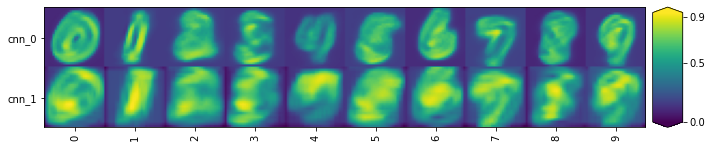

In [18]:
rel_model_name = ['Layercam'] #Gradcam, Gradcam++, Saliency, Scorecam, Layercam
layer_name = ['cnn_0','cnn_1'] #'conv\w*\s' ---errors, check...
model=best_est.model_
relM_,tmpr_ = Attention_maps(rel_model_name,layer_name,model,
                                    X_train,y_train,function_combination=np.amax,
                                    norm_c=False,norm_max_min=False,
                                    normalize_cam=True,
                                    layer_norm=True,gamma=2,
                                    plot_int=True,transpose=False)

In [19]:
model_2=tf.keras.Model(inputs=[model.input],outputs=[model.get_layer('out').output])
model_2.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 cnn_0 (Conv2D)              (None, 28, 28, 16)        800       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                          

In [37]:
# drop, and increase in confidence with Ec = I o Lc, and I, with relM
def Drop(model,x,y,cam):
  y_all=model.predict(x)  
  y_tilde_all=model.predict(x*cam)
  #get score.
  score_y_all = y_all[np.arange(len(y_all)),y]
  score_y_tilde_all = y_tilde_all[np.arange(len(y_tilde_all)),y]
  dif_score_per =  (score_y_all-score_y_tilde_all)/score_y_all
  # calculate result
  result = np.where(y_tilde_all.argmax(axis=1)==y,1,np.nan)
  result[result==1] =   dif_score_per[result==1]#-score_y_tilde_all[result==1]#/score_y_all[result==1]*100
  return result

In [38]:
# drop, and increase in confidence with Ec = I o Lc, and I, with relM
def Increase_conf(model,x,y,cam):
  y_all=model.predict(x)  
  y_tilde_all=model.predict(x*cam)
  #get score.
  score_y_all = y_all[np.arange(len(y_all)),y]
  score_y_tilde_all = y_tilde_all[np.arange(len(y_tilde_all)),y]
  # calculate result
  result = np.where(y_tilde_all.argmax(axis=1)==y,1,-1)
  result[result==1] =   np.where(score_y_all[result==1]<score_y_tilde_all[result==1],0,1)
  return result

In [39]:
result_drop = Drop(model_2,X_train,y_train,relM_[0])
np.mean(result_drop[result_drop>0])

0.1850907030081839

In [40]:
result_inc = Increase_conf(model_2,X_train,y_train,relM_[0])
np.unique(result_inc,return_counts=True)

(array([-1,  0,  1]), array([  56,  343, 4601]))

In [41]:
# otsu region
relM_otsu = np.copy(relM_[0])
for k in range(len(relM_[0])):
  val = filters.threshold_otsu(relM_[0][k])
  relM_otsu[k]=relM_[0][k]>val

In [42]:
result_inc_otsu = Increase_conf(model_2,X_train,y_train,relM_otsu)
np.unique(result_inc_otsu,return_counts=True)

(array([-1,  0,  1]), array([ 143, 1022, 3835]))

Salida modelo imagen original [[ -4.771673    0.8926058  17.44483    -0.7739584  -1.9937657 -11.906519
   -1.4724777  -3.1004407   0.8406256  -2.824676 ]] 
 Predicted label 2  and actual label 2
Salida modelo imagen original hadd layercam [[ -3.347738    0.6878407  14.712723   -1.0540183  -1.9750355 -10.164219
   -0.8667858  -2.7931073   0.861042   -2.4143267]] 
 Predicted label 2 and actual label 2
Salida modelo imagen original x layercam otsu mask  [[ -4.503649     0.86074007  16.883911    -0.8314755   -1.9741491
  -11.542311    -1.3295059   -3.0848446    0.8293259   -2.7379425 ]] 
 Predicted label 2 and actual label 2
17.4448299407959 ---  14.712722778320312 --- 16.8839111328125


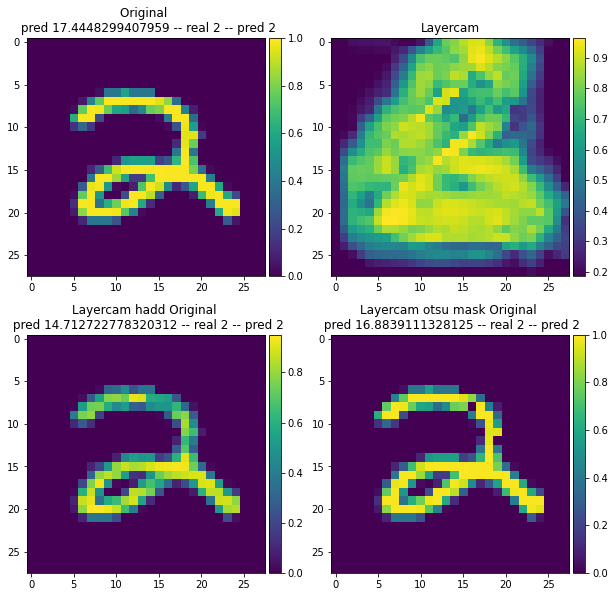

In [50]:
n=np.random.randint(len(y_train))
out_org=model_2.predict(X_train[n,:,:,0][np.newaxis,...,np.newaxis])
fig, axs = plt.subplots(2,2,figsize=(10,10))
z0plot=axs[0,0].imshow(X_train[n,:,:,0])
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z0plot, cax=cax, orientation='vertical')
axs[0,0].set_title(f'Original \n pred {out_org[0,y_train[n]]} -- real {y_train[n]} -- pred {np.argmax(out_org)}' )

z1plot=axs[0,1].imshow(relM_[0][n,:,:,0])
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z1plot, cax=cax, orientation='vertical')
axs[0,1].set_title('Layercam')

qq=(X_train[n,:,:,0]*relM_[0][n,:,:,0])
out_grad_ori=model_2.predict(qq[np.newaxis,...,np.newaxis])
z2plot=axs[1,0].imshow(qq)
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z2plot, cax=cax, orientation='vertical')
axs[1,0].set_title(f'Layercam hadd Original \n pred {out_grad_ori[0,y_train[n]]} -- real {y_train[n]} -- pred {np.argmax(out_grad_ori)}')

qq_2=(X_train[n,:,:,0]*relM_otsu[n,:,:,0])
out_grad_ori_norm=model_2.predict(qq_2[np.newaxis,...,np.newaxis])
z3plot=axs[1,1].imshow(qq_2)
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z3plot, cax=cax, orientation='vertical')
axs[1,1].set_title(f'Layercam otsu mask Original \n pred {out_grad_ori_norm[0,y_train[n]]} -- real {y_train[n]} -- pred {np.argmax(out_grad_ori_norm)}')





print(f"Salida modelo imagen original {out_org} \n Predicted label {np.argmax(out_org)}  and actual label {y_train[n]}")
print(f"Salida modelo imagen original hadd layercam {out_grad_ori} \n Predicted label {np.argmax(out_grad_ori)} and actual label {y_train[n]}")
print(f"Salida modelo imagen original x layercam otsu mask  {out_grad_ori_norm} \n Predicted label {np.argmax(out_grad_ori_norm)} and actual label {y_train[n]}")
print(f"{out_org[0,y_train[n]]} ---  {out_grad_ori[0,y_train[n]]} --- {out_grad_ori_norm[0,y_train[n]]}")

In [51]:
!git

usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone      Clone a repository into a new directory
   init       Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add        Add file contents to the index
   mv         Move or rename a file, a directory, or a symlink
   reset      Reset current HEAD to the specified state
   rm         Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect     Use binary search to find the commit that introduced a bug
   grep       Prin

# old

In [ ]:
def Confidence_index(model,x_train,y_train,tmpr):
    y_tilde=[]
    y=[]
    labels=[]
    for i in np.unique(y_train):
        idx = y_train==i
        labels.append(y_train[idx])
        x = x_train[idx]
        y_tilde.append(model.predict((x*tmpr[i,0,:,:,np.newaxis])))
        y.append(model.predict(x))
    y_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),y)
    labels_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),labels)
    y_tilde_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),y_tilde)
    result=[]
    for j in range(len(y_all)):
        if np.argmax(y_tilde_all[j])!=labels_all[j]:
            result.append(-1)
        elif y_tilde_all[j][labels_all[j]]>y_all[j][labels_all[j]]:
            result.append(1)
        else:
            result.append(0) 
    return result

In [ ]:
result = Confidence_index(model_2,X_train,y_train,tmpr_[0])

In [ ]:
np.unique(result,return_counts=True)
# -1 cambio de etiqueta (mal etiquetado)
# 0 se obtiene mejor puntuacion en modelo sin mascara
# 1 se obtiene mejor puntuacion en modelo con multiplciacion de mascara

(array([-1,  0,  1]), array([4414,  584,    2]))

In [ ]:
2269/(144+2269+2587),2587/(144+2269+2587)

(0.4538, 0.5174)

In [ ]:
X_train.shape,relM_[0].shape

((5000, 28, 28, 1), (5000, 28, 28, 1))

In [ ]:
def Confidence_index_2(model,x_train,y_train,relM):
  y_all=model.predict(x_train)  
  y_tilde_all=model.predict((x_train*relM)>0)
  result=[]
  for j in range(len(y_all)):
      if np.argmax(y_tilde_all[j])!=y_train[j]:
          result.append(-1)
      elif y_tilde_all[j][y_train[j]]>y_all[j][y_train[j]]:
          result.append(1)
      else:
          result.append(0) 
  return result

In [ ]:
result_2 = Confidence_index_2(model_2,X_train,y_train,relM_[0])

In [ ]:
np.unique(result_2,return_counts=True)
# -1 cambio de etiqueta (mal etiquetado)
# 0 se obtiene mejor puntuacion en modelo sin mascara
# 1 se obtiene mejor puntuacion en modelo con multiplciacion de mascara

(array([-1,  0,  1]), array([ 201, 2644, 2155]))

Salida modelo imagen original [[-1.2503389 -2.5158603  2.040604   1.2308546 -1.8607395 -1.0333112
  -3.025049  12.302218  -5.3048325  4.1241794]] 
 Predicted label 7  and actual label 7
Salida modelo imagen original x gradcam++ [[-1.0225035 -2.4504786  2.1899633  1.1337298 -1.4244684 -0.887424
  -3.0427864 11.614746  -5.132749   4.0832896]] 
 Predicted label 7 and actual label 7
Salida modelo imagen original x gradcam++ normalized [0,1] [[-1.0225035 -2.4504786  2.1899633  1.1337298 -1.4244684 -0.887424
  -3.0427864 11.614746  -5.132749   4.0832896]] 
 Predicted label 7 and actual label 7


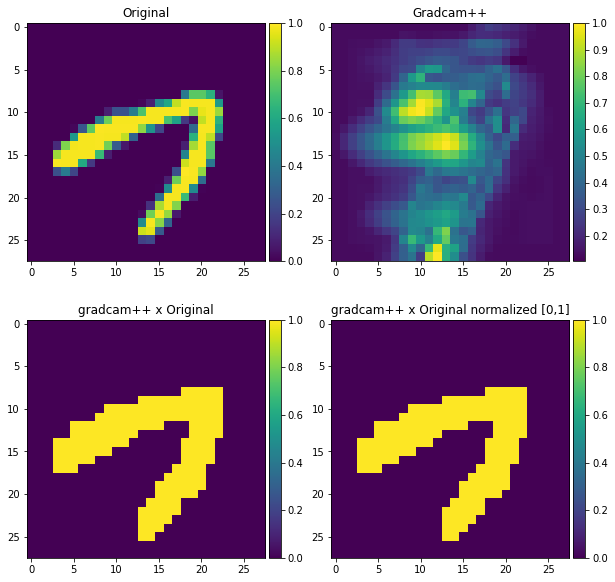

In [ ]:
### para train
n=np.random.randint(len(y_train))
fig, axs = plt.subplots(2,2,figsize=(10,10))
z0plot=axs[0,0].imshow(X_train[n,:,:,0])
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z0plot, cax=cax, orientation='vertical')
axs[0,0].set_title('Original')

z1plot=axs[0,1].imshow(relM_[0][n,:,:,0])
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z1plot, cax=cax, orientation='vertical')
axs[0,1].set_title('Gradcam++')

qq=(X_train[n,:,:,0]*relM_[0][n,:,:,0])>0
z2plot=axs[1,0].imshow(qq)
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z2plot, cax=cax, orientation='vertical')
axs[1,0].set_title('gradcam++ x Original')

qq_min_max=MinMaxScaler().fit_transform(qq)
z3plot=axs[1,1].imshow(qq_min_max)
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z3plot, cax=cax, orientation='vertical')
axs[1,1].set_title('gradcam++ x Original normalized [0,1]')

out_org=model_2.predict(X_train[n,:,:,0][np.newaxis,...,np.newaxis])
out_grad_ori=model_2.predict(qq[np.newaxis,...,np.newaxis])
out_grad_ori_norm=model_2.predict(qq_min_max[np.newaxis,...,np.newaxis])

print(f"Salida modelo imagen original {out_org} \n Predicted label {np.argmax(out_org)}  and actual label {y_train[n]}")
print(f"Salida modelo imagen original x gradcam++ {out_grad_ori} \n Predicted label {np.argmax(out_grad_ori)} and actual label {y_train[n]}")
print(f"Salida modelo imagen original x gradcam++ normalized [0,1] {out_grad_ori_norm} \n Predicted label {np.argmax(out_grad_ori_norm)} and actual label {y_train[n]}")


# score_confience_test

Gradcam++ class 0 layer cnn_0
Gradcam++ class 1 layer cnn_0
Gradcam++ class 2 layer cnn_0
Gradcam++ class 3 layer cnn_0
Gradcam++ class 4 layer cnn_0
Gradcam++ class 5 layer cnn_0
Gradcam++ class 6 layer cnn_0
Gradcam++ class 7 layer cnn_0
Gradcam++ class 8 layer cnn_0
Gradcam++ class 9 layer cnn_0


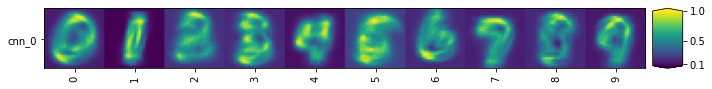

In [ ]:
rel_model_name = ['Gradcam++'] #Gradcam, Gradcam++, Saliency, Scorecam
layer_name = ['cnn_0']#,'cnn_1','cnn_2'] #'conv\w*\s' ---errors, check...
model=best_est.model_
relM_,tmpr_ = Attention_maps(rel_model_name,layer_name,model,
                                    X_test,y_test,function_combination=None,
                                    norm_c=True,norm_max_min=True,
                                    plot_int=False,transpose=False)

In [ ]:
model_2=tf.keras.Model(inputs=[model.input],outputs=[model.get_layer('out').output])

In [ ]:
result = Confidence_index(model_2,X_test,y_test,tmpr_[0])
np.unique(result,return_counts=True)

(array([-1,  0,  1]), array([ 464, 4409, 5127]))

In [ ]:
464+4409+ 5127,X_test.shape,X_train.shape

(10000, (10000, 28, 28, 1), (5000, 28, 28, 1))

In [ ]:
result_2 = Confidence_index_2(model_2,X_test,y_test,relM_[0])
np.unique(result_2,return_counts=True)

(array([-1,  0,  1]), array([1246, 5038, 3716]))

Salida modelo imagen original [[-0.3291565  -0.98607683  4.6023693   0.39329457 -2.636447   -3.0929368
  -1.4443188   1.5593889   1.4318688  -0.8996991 ]] 
 Predicted label 2  and actual label 2
Salida modelo imagen original x gradcam++ [[ 0.4587828  -1.8865546   7.5619903   0.82005674 -4.847105   -5.2025156
  -2.0804024   1.846105    2.4465044  -2.042477  ]] 
 Predicted label 2 and actual label 2
Salida modelo imagen original x gradcam++ normalized [0,1] [[ 0.4587828  -1.8865546   7.5619903   0.82005674 -4.847105   -5.2025156
  -2.0804024   1.846105    2.4465044  -2.042477  ]] 
 Predicted label 2 and actual label 2


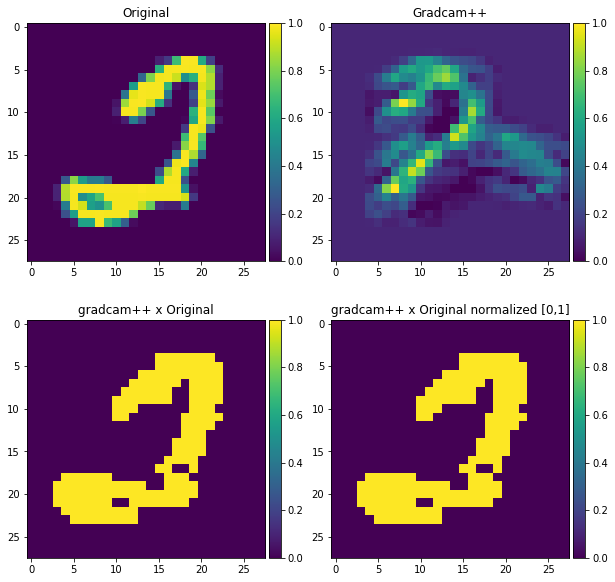

In [ ]:
# para test
n=np.random.randint(len(y_test))
fig, axs = plt.subplots(2,2,figsize=(10,10))
z0plot=axs[0,0].imshow(X_test[n,:,:,0])
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z0plot, cax=cax, orientation='vertical')
axs[0,0].set_title('Original')

z1plot=axs[0,1].imshow(relM_[0][n,:,:,0])
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z1plot, cax=cax, orientation='vertical')
axs[0,1].set_title('Gradcam++')

qq=(X_test[n,:,:,0]*relM_[0][n,:,:,0])>0
z2plot=axs[1,0].imshow(qq)
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z2plot, cax=cax, orientation='vertical')
axs[1,0].set_title('gradcam++ x Original')

qq_min_max=MinMaxScaler().fit_transform(qq)
z3plot=axs[1,1].imshow(qq_min_max)
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(z3plot, cax=cax, orientation='vertical')
axs[1,1].set_title('gradcam++ x Original normalized [0,1]')

out_org=model_2.predict(X_test[n,:,:,0][np.newaxis,...,np.newaxis])
out_grad_ori=model_2.predict(qq[np.newaxis,...,np.newaxis])
out_grad_ori_norm=model_2.predict(qq_min_max[np.newaxis,...,np.newaxis])

print(f"Salida modelo imagen original {out_org} \n Predicted label {np.argmax(out_org)}  and actual label {y_test[n]}")
print(f"Salida modelo imagen original x gradcam++ {out_grad_ori} \n Predicted label {np.argmax(out_grad_ori)} and actual label {y_test[n]}")
print(f"Salida modelo imagen original x gradcam++ normalized [0,1] {out_grad_ori_norm} \n Predicted label {np.argmax(out_grad_ori_norm)} and actual label {y_test[n]}")
